# dbitseq

In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd


import seaborn as sns
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

from src.interface import UnitedNet
from src.configs import *
from scipy.stats import spearmanr, pearsonr

In [2]:
def split_data(test_batch):
    adata_rna_train = adata_rna_all[adata_rna_all.obs['batch'] != test_batch]
    adata_morph_train = adata_morph_all[adata_morph_all.obs['batch'] != test_batch]
    adata_mrna_niche_train = adata_mrna_niche_all[adata_mrna_niche_all.obs['batch'] != test_batch]

    adata_rna_test = adata_rna_all[adata_rna_all.obs['batch'] == test_batch]
    adata_morph_test = adata_morph_all[adata_morph_all.obs['batch'] == test_batch]
    adata_mrna_niche_test = adata_mrna_niche_all[adata_mrna_niche_all.obs['batch'] == test_batch]

    return [adata_rna_train, adata_morph_train, adata_mrna_niche_train], [adata_rna_test, adata_morph_test,
                                                                          adata_mrna_niche_test]


In [3]:
from sklearn import preprocessing
def change_label(adata,batch):
    adata.obs['batch'] = batch
    adata.obs['imagecol'] = adata.obs['array_col']
    adata.obs['imagerow'] = adata.obs['array_row']
    adata.obs['label'] = adata.obs['cell_type']
    return adata

In [4]:
def pre_ps(adata_list,sc_pre = None):
    adata_list_all = [ad_x.copy() for ad_x in adata_list]
    scalars = []
    assert (adata_list_all[0].X>=0).all(), "poluted input"
    for idx, mod in enumerate(adata_list_all):
        t_x = mod.X
        if sc_pre != None:
            scaler = sc_pre[idx]
        else:
            scaler = preprocessing.StandardScaler().fit(t_x)
        t_x = scaler.transform(t_x)
        mod.X = t_x
        adata_list_all[idx] = mod
        scalars.append(scaler)

    return adata_list_all,scalars

# load dbitseq data

In [5]:
technique = 'dbitseq'
data_path = f"../data/{technique}"
device = "cuda:0"

In [6]:
adata_niche_rna_train = sc.read_h5ad(f'{data_path}/adata_niche_rna_train.h5ad')
adata_niche_rna_test = sc.read_h5ad(f'{data_path}/adata_niche_rna_test.h5ad')

adata_rna_train = sc.read_h5ad(f'{data_path}/adata_rna_train.h5ad')
adata_rna_test = sc.read_h5ad(f'{data_path}/adata_rna_test.h5ad')

adata_protein_train = sc.read_h5ad(f'{data_path}/adata_protein_train.h5ad')
adata_protein_test = sc.read_h5ad(f'{data_path}/adata_protein_test.h5ad')


In [7]:
adata_rna_train = change_label(adata_rna_train,'train')
adata_protein_train=change_label(adata_protein_train,'train')
adata_niche_rna_train=change_label(adata_niche_rna_train,'train')

adata_rna_test = change_label(adata_rna_test,'test')
adata_protein_test = change_label(adata_protein_test,'test')
adata_niche_rna_test = change_label(adata_niche_rna_test,'test')

adatas_train = [adata_rna_train, adata_protein_train, adata_niche_rna_train]
adatas_test = [adata_rna_test, adata_protein_test, adata_niche_rna_test]

adatas_all = []
for ad_train, ad_test in zip(adatas_train,adatas_test):
    ad_all = ad_train.concatenate(ad_test,batch_key='sample')
    ad_all = change_label(ad_all,'test')
    adatas_all.append(ad_all)
adatas_all,_ = pre_ps(adatas_all)    
    

adatas_train,_ = pre_ps(adatas_train)   
adatas_test,_ = pre_ps(adatas_test)   


/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


# Train and finetune UnitedNet

In [8]:
train_model = True
if train_model:
    technique = 'dbitseq'
    data_path = f"../data/{technique}"
    root_save_path = f"../saved_results/dbitseq"
    model = UnitedNet(root_save_path, device=device, technique=dbitseq_config)
    model.train(adatas_train,verbose=True)
    model.finetune(adatas_all,verbose=True)
else:
    technique = 'dbitseq'
    data_path = f"../data/{technique}"
    root_save_path = f"../saved_results/dbitseq"
    model = UnitedNet(root_save_path, device=device, technique=dbitseq_config)



training


  0%|          | 0/20 [00:00<?, ?it/s]



Losses                          Value
-------------------------  ----------
cross_entropy_loss_head_0   0.229228
self_entropy_loss_head_0   -0.0247128
self_entropy_loss_head_8   -0.0242391
cross_entropy_loss_head_6   0.224649
self_entropy_loss_head_3   -0.0249332
self_entropy_loss_head_1   -0.0245466
self_entropy_loss_head_6   -0.0247959
cross_entropy_loss_head_1   0.244681
cross_entropy_loss_head_3   0.220966
translation_loss            0.828372
cross_entropy_loss_head_4   0.231455
discriminator_loss          0.0500271
generator_loss              0.0238487
self_entropy_loss_head_2   -0.0244804
cross_entropy_loss_head_9   0.232208
self_entropy_loss_head_9   -0.0241348
reconstruction_loss         0.700729
cross_entropy_loss_head_8   0.241194
self_entropy_loss_head_5   -0.0234128
self_entropy_loss_head_4   -0.0245166
cross_entropy_loss_head_5   0.246249
cross_entropy_loss_head_7   0.232196
contrastive_loss            0.252782
cross_entropy_loss_head_2   0.22623
self_entropy_loss_head_7

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:06<02:08,  6.78s/it]



Metrics    Value
---------  ------------------------------------------
r2         [[ 0.00214555 -0.00234224 -0.001194  ]
            [ 0.62757759  0.79974514  0.34424675]
            [ 0.05721843  0.00426301  0.09592154]]
confusion  [[26  9  0  0 31  0  3  0  0 12  0  0  0]
            [ 9  9 30  0 14  0  0  0  0 21  0  0  0]
            [19  1 71  2  3  0  0  2  0 25  0  1  0]
            [ 0  1 30 55  8  0  3  0  0  3  0 21  0]
            [12  4 69  0 73  0  1  0  0  6  0  0  0]
            [ 0  6 22  0 30  0  0  0  0 14  0  0  0]
            [ 0  6  0  2  3  0  6  0  0  0  0  0  0]
            [ 0  0  4  1  0  0  0  0  0  1  0  0  0]
            [ 0  0  0  4  0  0  5  0  0  0  0  0  0]
            [ 0  0  0  0  0  0 14  0  0 30  0  0  0]
            [ 0  8  0  1  8  0  0  0  0  0  2  0  0]
            [ 0  0  0  0  0  0  2  0  0  2  0  0  0]
            [ 0  0  0  0  2  0  0  0  0  1  0  0  0]]
acc        0.36363636363636365
ari        0.15516805219781235
nmi        0.31049655271

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:13<02:02,  6.83s/it]



Metrics    Value
---------  ------------------------------------------
r2         [[0.04732084 0.00394399 0.03646913]
            [0.69414906 0.82384735 0.36395452]
            [0.24190273 0.04585611 0.28359781]]
confusion  [[65 10  2  0  0  0  0  0  0  1  0  2  1]
            [ 3 50  0  0  2  0  0 18  0  0  0  2  8]
            [24  0 48  4 24  0  0  2  0  0  0 22  0]
            [ 0  0  0 71  0  0  0  0  0  0 50  0  0]
            [42  3  1  0 69  7  0  0  0  0  0  0 43]
            [15 16  0  0 17 18  0  0  0  0  0  4  2]
            [ 0  0  0  5  0  0  4  0  0  0  8  0  0]
            [ 0  0  0  1  4  0  0  1  0  0  0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0]
            [ 4  0  0  0  0  0  0  0  0 40  0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0 14  0  3]
            [ 0  0  0  0  2  0  0  1  0  1  0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  1]]
acc        0.5093582887700535
ari        0.32284686074889085
nmi        0.5368895709516983


Lo

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:19<01:52,  6.60s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.07992495 0.00844031 0.06321419]
            [0.76794384 0.86296667 0.4292985 ]
            [0.29688731 0.05698649 0.34514599]]
confusion  [[ 76   2   0   0   0   2   0   1   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  8   0  93   3   3   0   0   0   0   0  11   0   6]
            [  0   0   5 109   0   0   0   0   5   0   2   0   0]
            [ 11   0  66   0  48  33   1   6   0   0   0   0   0]
            [  0   0  10   0   1  44   0  17   0   0   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   3   0   0   0   0   3   0]
            [  0   0   1   0   0   0   7   0   1   0   0   0   0]
            [  0   0   0   0   0   0   5   0   0  39   0   0   0]
            [  0   1   0  11   7   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:26<01:45,  6.58s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.09819805 0.02342006 0.08605701]
            [0.74620191 0.83617393 0.46183139]
            [0.32648182 0.09049274 0.38905785]]
confusion  [[ 79   1   0   0   0   1   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  4   0  55  14  14   0   0  30   7   0   0   0   0]
            [  0   0   0 121   0   0   0   0   0   0   0   0   0]
            [  4   0  37   0  69  26   0   0   0   0  29   0   0]
            [  0   0   0   0   0  69   0   0   0   2   1   0   0]
            [  0   0   0   0   0   3  14   0   0   0   0   0   0]
            [  0   0   0   0   0   1   4   0   0   0   0   1   0]
            [  0   0   0   0   0   0   9   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  3   1   0  15   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:33<01:40,  6.71s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.10771299 0.03858088 0.08974627]
            [0.78242497 0.88738992 0.52345711]
            [0.34463073 0.12536557 0.40322612]]
confusion  [[ 81   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  3   3  65   3   3   0   0  14   0   0   0   0  33]
            [  0   0   0 108   0   0   0   1   0   0  12   0   0]
            [  4   0  21   0 139   0   0   0   0   0   1   0   0]
            [ 10   9   0   1   0  50   0   0   0   2   0   0   0]
            [  0   0   0   0   0   8   9   0   0   0   0   0   0]
            [  0   0   6   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   9   0   0   0   0   0   0]
            [  4   0   0   0   0   0   0   0   0  40   0   0   0]
            [  0   1   0  16   0   0   0   0   0   0   2   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:40<01:36,  6.87s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.11046718 0.03840031 0.09629644]
            [0.79652355 0.88245138 0.59132093]
            [0.35641196 0.107974   0.42364344]]
confusion  [[ 72   1   0   0   3   5   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   1  96   0   1   0   4   0   0   0   0   0  22]
            [  0   0   1  62   0   0  43  15   0   0   0   0   0]
            [  0   0   4   0 159   0   1   1   0   0   0   0   0]
            [  0   0   0   0   0  70   0   0   0   2   0   0   0]
            [  0   0   0   0   0  13   0   0   4   0   0   0   0]
            [  0   0   4   0   0   0   0   1   0   0   0   1   0]
            [  0   0   0   0   1   0   0   0   8   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  0   0   0  19   0   0   0   0   0   0   0   0   0]
            [  0   0   1   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:48<01:35,  7.31s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.11806213 0.04223996 0.10972007]
            [0.73549376 0.86222778 0.61070937]
            [0.35497682 0.13420509 0.44654329]]
confusion  [[ 81   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   1  94   1   0   0   1  12  15   0   0   0   0]
            [  1   0   0 105   0   0   2   0  13   0   0   0   0]
            [  5   0   1   0 148  10   0   0   1   0   0   0   0]
            [  0   0   0   0   0  33  32   0   0   7   0   0   0]
            [  0   0   0   0   0   0   5   0  12   0   0   0   0]
            [  0   0   0   0   0   0   0   5   0   1   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [ 19   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0   1   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:57<01:31,  7.66s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.12985472 0.05121461 0.11422463]
            [0.80225023 0.87171523 0.55913062]
            [0.40745731 0.1820353  0.47135402]]
confusion  [[ 81   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  1  12  51  14   0  16  30   0   0   0   0   0   0]
            [  2   1   0 105   0   3  10   0   0   0   0   0   0]
            [ 13   0   2   1 107   5   2   0   0   0   0   0  35]
            [  0   0   0   0   0  47   0   0   0   4   0   0  21]
            [  0   0   0   0   0   7  10   0   0   0   0   0   0]
            [  0   0   0   3   0   0   2   1   0   0   0   0   0]
            [  0   0   0   0   0   0   9   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [ 18   1   0   0   0   0   0   0   0   0   0   0   0]
            [  2   0   0   0   0   1   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [01:06<01:28,  8.06s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.12484433 0.0524905  0.11276565]
            [0.79660757 0.88085485 0.5622455 ]
            [0.4027581  0.18633947 0.47173632]]
confusion  [[ 79   0   0   0   1   0   0   0   0   0   0   0   1]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0  99   6   0   0   9   0  10   0   0   0   0]
            [  0   0   0 108   0   0   1   0  12   0   0   0   0]
            [  1   0   6   0 133   0   0   0   0   0   0   0  25]
            [  0   0   0   0   1  41  19   0   0   3   0   0   8]
            [  0   0   0   0   0   0  14   0   3   0   0   0   0]
            [  0   3   0   2   0   0   0   1   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [ 18   0   0   1   0   0   0   0   0   0   0   0   0]
            [  0   0   0   3   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [01:14<01:21,  8.19s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.13874544 0.06002932 0.11820784]
            [0.81814311 0.88327984 0.67591689]
            [0.41107319 0.21264866 0.47896489]]
confusion  [[ 76   0   0   0   3   0   0   0   0   1   0   0   1]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0  64   0   0   0  50   0  10   0   0   0   0]
            [  0   0   4 100   0   0  11   0   6   0   0   0   0]
            [  0   1   5   0 113   2   0  19   0   0   0   0  25]
            [  0   0   0   0   0  54  15   0   0   3   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   2   0   0   0   4   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [ 15   3   0   1   0   0   0   0   0   0   0   0   0]
            [  0   0   0   1   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [01:21<01:10,  7.87s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.13971199 0.06589925 0.12304747]
            [0.8210572  0.9144472  0.65347618]
            [0.41762494 0.22132451 0.49333112]]
confusion  [[ 70   0   0   0   2   0   0   3   0   2   0   0   4]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  7   3  66   0   0   0  44   0   4   0   0   0   0]
            [  0   0   7 102   0   0  12   0   0   0   0   0   0]
            [  0   0   0   0 136   0   0  13   0   1   0   0  15]
            [  0   0   0   0   0  66   3   0   0   3   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [ 14   1   0   0   0   0   0   0   0   4   0   0   0]
            [  0   0   0   2   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [01:29<01:01,  7.67s/it]



Metrics    Value
---------  ------------------------------------------
r2         [[0.1384831  0.06541042 0.12210834]
            [0.82386236 0.91380731 0.69087796]
            [0.42385298 0.21522865 0.49863447]]
confusion  [[81  0  0  0  0  0  0  0  0  0  0  0  0]
            [ 0 83  0  0  0  0  0  0  0  0  0  0  0]
            [ 1  4 65  2  0  0 44  0  8  0  0  0  0]
            [ 0  0 19 95  0  0  0  0  7  0  0  0  0]
            [ 0  1  0  0 85  0  2 55  0  0  0  0 22]
            [ 1  0  0  0  0 68  0  0  0  3  0  0  0]
            [ 0  0 17  0  0  0  0  0  0  0  0  0  0]
            [ 0  0  0  0  0  0  0  6  0  0  0  0  0]
            [ 0  0  0  0  0  0  0  0  9  0  0  0  0]
            [ 0  0  0  0  0  0  0  0  0 44  0  0  0]
            [ 9 10  0  0  0  0  0  0  0  0  0  0  0]
            [ 0  0  0  3  0  0  0  0  0  1  0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  3]]
acc        0.7205882352941176
ari        0.6341957366620615
nmi        0.7863166997658316


/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [01:35<00:51,  7.32s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14048636 0.07121828 0.11990229]
            [0.82689571 0.91248925 0.63030106]
            [0.41224464 0.19267793 0.48689229]]
confusion  [[ 78   0   0   2   0   0   0   0   0   0   0   0   1]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0  11  96   0   0   0  12   0   5   0   0   0   0]
            [  0   0  69  43   0   0   0   0   9   0   0   0   0]
            [  2   0   0   0 100  27   3  21   0   4   0   0   8]
            [  0   0   8   0   0  64   0   0   0   0   0   0   0]
            [  0   0  16   0   0   1   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  0  15   0   0   0   0   0   0   0   4   0   0   0]
            [  0   0   0   1   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [01:41<00:42,  7.04s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14062734 0.0516693  0.11750814]
            [0.81969305 0.89805966 0.66933319]
            [0.42283438 0.20024195 0.45437434]]
confusion  [[ 76   0   0   0   0   0   0   0   0   0   0   0   5]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0  91   0   0   0  29   0   4   0   0   0   0]
            [  0   0  60  52   0   0   0   0   9   0   0   0   0]
            [  1   0   0   0 135   1   1  27   0   0   0   0   0]
            [  0   0   5   0   0  67   0   0   0   0   0   0   0]
            [  0   0   7   0   0  10   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   1   0   0   0   0   0  43   0   0   0]
            [  3  15   0   0   0   0   0   0   0   1   0   0   0]
            [  1   0   0   2   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:48<00:34,  6.87s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14251251 0.06867536 0.12469046]
            [0.80825427 0.84401595 0.66262281]
            [0.41453666 0.22593043 0.48297356]]
confusion  [[ 78   0   0   0   0   0   0   0   0   0   0   0   3]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 123   0   0   0   0   0   1   0   0   0   0]
            [  0   0   0 108   0   0   7   0   6   0   0   0   0]
            [  3   0   1   0 115  24   0  22   0   0   0   0   0]
            [  0   0   0   0   0  72   0   0   0   0   0   0   0]
            [  0   0   0   0   0  12   5   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  1  17   0   0   0   0   0   0   0   1   0   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:55<00:27,  6.80s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.13969674 0.07136361 0.11820283]
            [0.80968729 0.88664779 0.68492977]
            [0.42086864 0.23698526 0.50055295]]
confusion  [[ 72   0   0   0   0   2   0   0   0   0   7   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   3 120   0   0   0   0   0   0   0   1   0   0]
            [  0   0   0 107   0   0  10   0   4   0   0   0   0]
            [  1   0   0   0 152   2   0  10   0   0   0   0   0]
            [  0   0   0   0   0  72   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  4  10   0   0   0   0   0   0   0   5   0   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [02:01<00:20,  6.80s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14034661 0.07267809 0.12167177]
            [0.82636296 0.89630068 0.68614538]
            [0.42744791 0.23469639 0.50273095]]
confusion  [[ 78   3   0   0   0   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  1   0 122   0   0   0   0   0   0   0   0   1   0]
            [  0   0   0 106   0   0   4   0   7   4   0   0   0]
            [  6   0   9   0 123   2   0  25   0   0   0   0   0]
            [  0   8   0   0   0  64   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  6  13   0   0   0   0   0   0   0   0   0   0   0]
            [  0   1   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [02:09<00:13,  6.90s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14775237 0.07713536 0.12873351]
            [0.82049946 0.86180853 0.71758967]
            [0.44294877 0.23631384 0.51378546]]
confusion  [[ 80   1   0   0   0   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 124   0   0   0   0   0   0   0   0   0   0]
            [  0   1   0  99   0   0  17   0   4   0   0   0   0]
            [ 22   1  17   0  92   0   0  33   0   0   0   0   0]
            [  1  13   0   0   0  58   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  4  15   0   0   0   0   0   0   0   0   0   0   0]
            [  0   2   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [02:17<00:07,  7.28s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.13351632 0.0732646  0.10766943]
            [0.83438897 0.90214874 0.69587107]
            [0.43776741 0.23464922 0.48125274]]
confusion  [[ 70   3   0   3   5   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   1 123   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0 119   0   0   1   0   1   0   0   0   0]
            [  0   0  14   0 120   0   0  31   0   0   0   0   0]
            [  0   6   0   0   0  66   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [  4  14   0   0   0   0   0   0   1   0   0   0   0]
            [  0   0   0   4   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [02:25<00:00,  7.26s/it]




Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14318241 0.08356692 0.12228577]
            [0.85130201 0.90568696 0.7076782 ]
            [0.43304205 0.25923709 0.5045008 ]]
confusion  [[ 77   0   0   3   1   0   0   0   0   0   0   0   0]
            [  0  83   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 124   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0 120   0   0   0   0   1   0   0   0   0]
            [  0   1  12   0 124   0   0  28   0   0   0   0   0]
            [  4   4   0   0  15  49   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   6   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   9   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  44   0   0   0]
            [ 19   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   3   0   0   0   0  

  0%|          | 0/10 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_1            0.127484
self_entropy_loss_head_0  -0.015205
self_entropy_loss_head_8  -0.0127305
self_entropy_loss_head_3  -0.0130045
ddc_loss_head_4            0.134878
self_entropy_loss_head_1  -0.0147293
self_entropy_loss_head_6  -0.0143893
ddc_loss_head_7            0.137075
ddc_loss_head_9            0.133414
self_entropy_loss_head_2  -0.0139728
ddc_loss_head_8            0.13311
ddc_loss_head_2            0.133015
self_entropy_loss_head_9  -0.0133513
reconstruction_loss        0.47908
ddc_loss_head_3            0.13395
ddc_loss_head_5            0.133857
self_entropy_loss_head_5  -0.0133199
ddc_loss_head_0            0.132584
self_entropy_loss_head_4  -0.0145087
ddc_loss_head_6            0.132339
self_entropy_loss_head_7  -0.01346
best_head                  5
best model saved at ../saved_results/dbitseq/finetune_best.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 1/10 [00:09<01:23,  9.26s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.1473834  0.07743402 0.12044652]
            [0.82695864 0.90760952 0.64385532]
            [0.44596308 0.23888958 0.50776819]]
confusion  [[ 99   0   0   0   0   0   0   0   0   2   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 155   0   0   0   0   0   0   0   0   0   0]
            [  1   0   0 149   0   0   0   0   1   0   0   0   0]
            [  1   0   0   0 134   1   0  71   0   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  4   0   0   0   0   0  17   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   7   0   0   0   0   0]
            [  0   0   0   1   0   0   0   0  11   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [ 23   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 2/10 [00:18<01:14,  9.37s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.14666096 0.08402145 0.12223456]
            [0.78581767 0.92324446 0.63314058]
            [0.45019706 0.24442345 0.53861781]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 155   0   0   0   0   0   0   0   0   0   0]
            [  1   0   0 150   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 131   0   0  76   0   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   7   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0  12   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [ 23   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 3/10 [00:28<01:05,  9.39s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.15441294 0.08489399 0.12609256]
            [0.84477838 0.89848425 0.6067949 ]
            [0.4659943  0.26399259 0.53268738]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 155   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 125   0   0  82   0   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   7   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 4/10 [00:38<00:58,  9.74s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.15616376 0.08717819 0.13160637]
            [0.83345178 0.91551532 0.65926199]
            [0.46963322 0.27025296 0.53637912]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 153   2   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 112   0   0  95   0   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   7   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 5/10 [00:48<00:49,  9.96s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.16073126 0.08813338 0.13837854]
            [0.83920682 0.91698973 0.71641758]
            [0.47010838 0.26759427 0.54839042]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 152   3   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 136   0   0  71   0   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   7   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 6/10 [01:00<00:42, 10.58s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.15848766 0.08525158 0.13780757]
            [0.83701329 0.8996312  0.64296145]
            [0.46948441 0.26351415 0.55154508]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 154   1   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 132   0   0   0  74   0   1   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  0   0   7   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 7/10 [01:09<00:30, 10.21s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.15971386 0.09048066 0.13896575]
            [0.85567931 0.92425835 0.70386582]
            [0.46749026 0.28089976 0.53300159]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 153   2   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 122   1   0   0  84   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  3   0   4   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   5   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 8/10 [01:19<00:20, 10.08s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.1612359  0.09095195 0.13770962]
            [0.85750086 0.92405675 0.72989998]
            [0.4622716  0.28323081 0.5344374 ]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 155   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 143   0   0  63   0   0   1   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  6   0   1   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   6   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 9/10 [01:29<00:10, 10.08s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.16161676 0.09318347 0.1421929 ]
            [0.84539162 0.91196509 0.70267452]
            [0.47094565 0.29104921 0.5520352 ]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 155   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 129   0   0   0  78   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  0   0   7   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  0   0   0   0   0   0   0   0  

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 10/10 [01:39<00:00,  9.91s/it]



Metrics    Value
---------  -------------------------------------------------------
r2         [[0.16769185 0.09634189 0.14431282]
            [0.86002356 0.92212312 0.7381168 ]
            [0.48696012 0.28913256 0.55482376]]
confusion  [[101   0   0   0   0   0   0   0   0   0   0   0   0]
            [  0 104   0   0   0   0   0   0   0   0   0   0   0]
            [  0   0 155   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0 151   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0 135   0   0  72   0   0   0   0   0]
            [  0   0   0   0   0  90   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0  21   0   0   0   0   0   0]
            [  3   1   3   0   0   0   0   0   0   0   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  12   0   0]
            [  0   0   0   0   0   0   0   0   0  55   0   0   0]
            [  0   0   0   0   0   0   0   0   0   0  23   0   0]
            [  6   0   0   0   0   0   0   0  

# Predict on all data

In [10]:

import torch
model = UnitedNet(root_save_path, device=device, technique=dbitseq_config)
model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
model.model.device_in_use = device
predict_label = model.predict_label(adatas_all)

print(root_save_path,'ari:',adjusted_rand_score(adatas_all[0].obs['cell_type'],
                    predict_label))

../saved_results/dbitseq ari: 0.7177405949292298


In [11]:
from src.data import create_dataloader
dataloader_test = create_dataloader(
    model.model,
    adatas_train,
    shuffle=False,
    batch_size=model.model.config["train_batch_size"],
)

In [12]:
#smooth and plot results

coord=np.array((list(adatas_all[0].obs['array_row'].astype('int')),
                list(adatas_all[0].obs['array_col'].astype('int')))).T


united_clus=list(predict_label)

coord=np.array((list(adatas_all[0].obs['array_row'].astype('int')),
                list(adatas_all[0].obs['array_col'].astype('int')))).T

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coord)
distances,indices = nbrs.kneighbors(coord)

united_clus_new=[]
for indi,i in enumerate(united_clus):
  np.array(united_clus)[(indices[indi])]
  occurence_count=Counter(np.array(united_clus)[(indices[indi])])
  united_clus_new.append(occurence_count.most_common(1)[0][0])
    

cluster_pl = sns.color_palette('tab20',20)
color_list = [cluster_pl[5],
 cluster_pl[1],
 cluster_pl[2],
 cluster_pl[4],
 cluster_pl[11],
 cluster_pl[6],
 cluster_pl[3],
 cluster_pl[7],
 cluster_pl[8],
 cluster_pl[0]]    

(0.8500000000000001, 48.15, 8.15, 48.85)

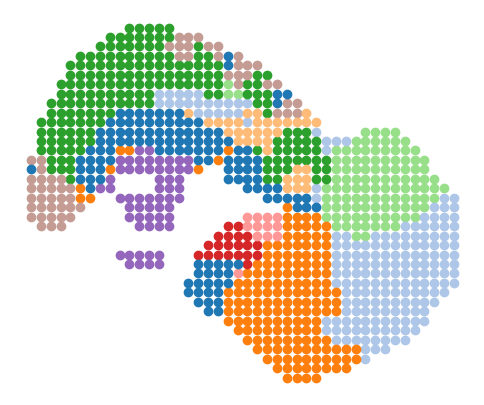

In [13]:
plt.figure(figsize=(6,5))
for idx,clus_id in enumerate(set(united_clus_new)):
    
    plt.scatter(adatas_all[0].obs['array_row'][(united_clus_new==clus_id)],
               adatas_all[0].obs['array_col'][(united_clus_new==clus_id)],
               color=color_list[idx],cmap='tab20')
plt.axis('off')
